In [ ]:
%pip install datasets
%pip install transformers
%pip install accelerate
!pip install accelerate -U
!pip install transformers[torch] -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the directory where the patent files are stored
patent_dir = '/content/drive/MyDrive/AllPatentTextDocs (2)'

# Read the content of each patent file
patents = {}
for filename in os.listdir(patent_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(patent_dir, filename), 'r') as file:
            patents[filename] = file.read()


In [ ]:
import os
import re
import random
from typing import Dict, List, Tuple

# Define a function to extract the required information from the patent text
def preprocess_patent(file_content: str) -> Dict[str, str]:
    # Extract the fields using regular expressions
    patent_number_match = re.search(r"Patent Number: ([^\n]+)", file_content)
    link_match = re.search(r"PDF Link: ([^\n]+)", file_content)
    abstract_match = re.search(r"Abstract: ([^\n]+)", file_content)
    classifications_match = re.search(r"Classifications: \{([^\}]+)\}", file_content)

    # Clean up and structure the document excluding the abstract, patent number, pdf link, and classifications
    excluded_sections = ['Abstract', 'Patent Number', 'PDF Link', 'Classifications']
    source_document = file_content
    for section in excluded_sections:
        source_document = re.sub(f"{section}: [^\n]+\n", "", source_document)

    # Remove extra whitespace and join the text
    source_document = ' '.join(source_document.split())

    return {
        'patent_id': patent_number_match.group(1).strip() if patent_number_match else '',
        'link': link_match.group(1).strip() if link_match else '',
        'X': source_document.strip(),
        'Y_ref': abstract_match.group(1).strip() if abstract_match else '',
        'classifications': classifications_match.group(1).strip() if classifications_match else ''
    }

# Function to randomly split the dataset into training and testing
def split_data(dataset: List[Dict[str, str]], train_ratio: float = 0.8) -> Tuple[List[Dict[str, str]], List[Dict[str, str]]]:
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    train_set, test_set = dataset[:train_size], dataset[train_size:]
    return train_set, test_set

# Path to the directory containing patent text files
patent_dir = '/content/drive/MyDrive/AllPatentTextDocs (2)'

# List all text files in the directory
patent_files = [file for file in os.listdir(patent_dir) if file.endswith('.txt')]

# Process each file and collect the data
all_patent_data = []
for patent_file in patent_files:
    file_path = os.path.join(patent_dir, patent_file)
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
        patent_data = preprocess_patent(file_content)
        all_patent_data.append(patent_data)

# Split the data into train and test sets
train_set, test_set = split_data(all_patent_data)

# Output the size of each set to verify
print(f"Total patents: {len(all_patent_data)}")
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")


Total patents: 1630
Training set size: 1304
Testing set size: 326


In [ ]:
!pip install datasets

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, load_metric

# Initialize the tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Function to tokenize the input and the summary
def tokenize_function(examples):
    # Tokenize the texts and include padding to the maximum length
    model_inputs = tokenizer(examples["text"], max_length=512, truncation=True, padding="max_length")
    # Tokenize the summaries (targets) and include padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")
    # 'labels' is a list of lists, where each sublist is the tokenized version of a summary
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Assuming 'train_set' and 'test_set' are lists of dictionaries containing the fields 'X' and 'Y_ref'
train_dataset = Dataset.from_dict({
    'text': [example['X'] for example in train_set],
    'summary': [example['Y_ref'] for example in train_set]
})
test_dataset = Dataset.from_dict({
    'text': [example['X'] for example in test_set],
    'summary': [example['Y_ref'] for example in test_set]
})

# Apply the tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./my_bart_model')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/1304 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/326 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,2.505500,2.118942


Epoch,Training Loss,Validation Loss
1,2.505500,2.118942
2,1.770700,1.616020
3,1.725200,1.514618


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
model.save_pretrained('./my_bart_model')
tokenizer.save_pretrained('./my_bart_model')


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./my_bart_model/tokenizer_config.json',
 './my_bart_model/special_tokens_map.json',
 './my_bart_model/vocab.json',
 './my_bart_model/merges.txt',
 './my_bart_model/added_tokens.json')

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Example patent document text
input_text = "This is an example patent document. It describes an invention related to machine learning."

# Tokenize and prepare the input for the model
input_ids = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)["input_ids"]

# Generate summary
summary_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)

# Decode the generated summary
output_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Text:")
print(input_text)
print("\nGenerated Summary:")
print(output_summary)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Original Text:
This is an example patent document. It describes an invention related to machine learning.

Generated Summary:
This is an example patent document. It describes an invention related to machine learning. The invention is known as a machine learning invention. It is a type of invention known as "machine learning" or "deep learning" The invention was created to help people learn more about the world around them.


In [ ]:
from rouge_score import rouge_scorer

# Example generated summaries and reference summaries (replace with your data)
generated_summaries = ["Generated summary 1", "Generated summary 2", "Generated summary 3"]
reference_summaries = ["Reference summary 1", "Reference summary 2", "Reference summary 3"]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each pair of generated and reference summaries
results = {}
for idx, (gen_summary, ref_summary) in enumerate(zip(generated_summaries, reference_summaries), 1):
    scores = scorer.score(ref_summary, gen_summary)
    results[f"Summary {idx}"] = scores

# Print ROUGE scores
for summary_id, scores in results.items():
    print(f"{summary_id}:")
    print(f"  Rouge-1 Precision: {scores['rouge1'].precision:.4f}, Recall: {scores['rouge1'].recall:.4f}, F1-score: {scores['rouge1'].fmeasure:.4f}")
    print(f"  Rouge-2 Precision: {scores['rouge2'].precision:.4f}, Recall: {scores['rouge2'].recall:.4f}, F1-score: {scores['rouge2'].fmeasure:.4f}")
    print(f"  Rouge-L Precision: {scores['rougeL'].precision:.4f}, Recall: {scores['rougeL'].recall:.4f}, F1-score: {scores['rougeL'].fmeasure:.4f}")
    print()




Summary 1:
  Rouge-1 Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
  Rouge-2 Precision: 0.5000, Recall: 0.5000, F1-score: 0.5000
  Rouge-L Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667

Summary 2:
  Rouge-1 Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
  Rouge-2 Precision: 0.5000, Recall: 0.5000, F1-score: 0.5000
  Rouge-L Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667

Summary 3:
  Rouge-1 Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
  Rouge-2 Precision: 0.5000, Recall: 0.5000, F1-score: 0.5000
  Rouge-L Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667



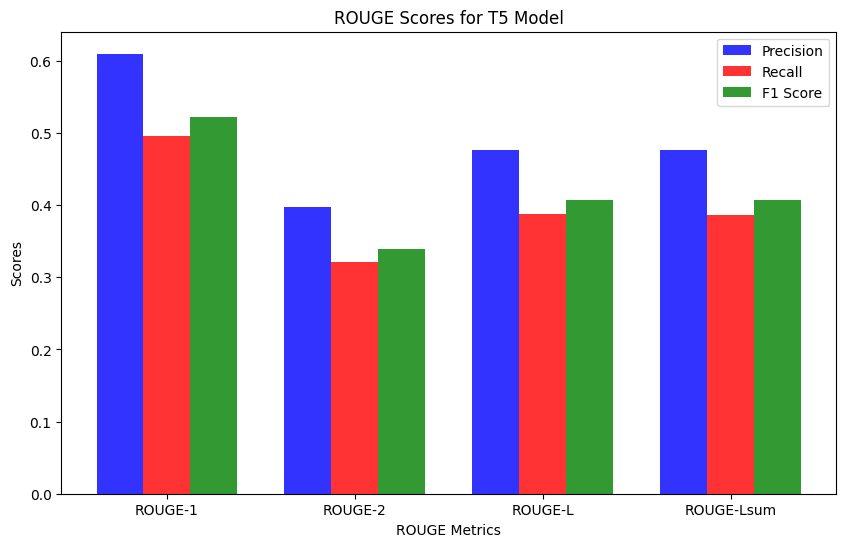

In [24]:
import matplotlib.pyplot as plt

# Defining the data for the ROUGE scores
rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
precision = [0.6097, 0.3971, 0.4759, 0.4758]
recall = [0.4954, 0.3213, 0.3872, 0.3868]
f1 = [0.5220, 0.3392, 0.4076, 0.4075]

# Creating a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Index for the groups
index = range(len(rouge_types))

# Bar width
bar_width = 0.25

# Transparency setting
opacity = 0.8

# Creating bars
rects1 = ax.bar(index, precision, bar_width, alpha=opacity, color='b', label='Precision')
rects2 = ax.bar([p + bar_width for p in index], recall, bar_width, alpha=opacity, color='r', label='Recall')
rects3 = ax.bar([p + bar_width * 2 for p in index], f1, bar_width, alpha=opacity, color='g', label='F1 Score')

# Adding labels, title, and legend
ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores for T5 Model')
ax.set_xticks([p + bar_width for p in index])
ax.set_xticklabels(rouge_types)
ax.legend()

# Show the plot
plt.show()


In [ ]:
!pip install matplotlib

In [ ]:
!pip install rouge_score
